# Data Scraping

### 1. Load and Parse HTML
- Reads a local HTML file containing a table of the most streamed songs on Spotify.
- Uses `BeautifulSoup` to parse the HTML and locate the first `<table>` element.

### 2. Extract and Save Table Data
- Parses the table into a pandas DataFrame using `pandas.read_html()`.
- Saves the DataFrame to a CSV file named `chartmasters_all_columns567.csv`.

### 3. Process Song Data
- Loads the saved CSV file.
- Splits the "Artist and Title" column into two separate columns: "Artist" and "Song".
- Adds a "Genre" column.

### 4. Fetch Genre from AllMusic
- Defines a function to search for each track on AllMusic.com.
- Extracts the genre listed on the track's page, if available.

### 5. Annotate and Save Updated Data
- Loops through entries with missing genre data.
- Fetches and updates genre information using the AllMusic function.
- Periodically saves progress to a CSV.
- Final results are saved to `chartmasters_with_genres_artist_based.csv`.

In [ ]:
!pip install BeautifulSoup
!pip install lxml

In [ ]:
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd
import time
import os

In [ ]:
# Path to your HTML file
html_file_path = r"Spotify Most Streamed Songs of All Time.html"

# Load and parse the HTML
with open(html_file_path, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "html.parser")

# Try to find the first table (regardless of class)
tables = soup.find_all("table")
if not tables:
    print("No tables found in the HTML file.")
else:
    # Use pandas to parse the first table
    df_list = pd.read_html(str(tables[0]))  # Parse first table found
    df = df_list[0]

    # Save to CSV
    output_file = "chartmasters_all_columns567.csv"
    df.to_csv(output_file, index=False)
    print(f" Extracted and saved {len(df)} rows to {output_file}")

 Extracted and saved 2500 rows to chartmasters_all_columns567.csv


C:\Users\dell\AppData\Local\Temp\ipykernel_15208\2057844699.py:14: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_list = pd.read_html(str(tables[0]))  # Parse first table found


In [ ]:
print(" Working directory:", os.getcwd())

headers = {"User-Agent": "Mozilla/5.0"}

def get_allmusic_genre_by_artist(artist):
    try:
        query = artist.strip().replace(" ", "+")
        search_url = f"https://www.allmusic.com/search/artists/{query}"
        search_resp = requests.get(search_url, headers=headers, timeout=10)
        search_soup = BeautifulSoup(search_resp.text, "html.parser")

        artist_link = search_soup.select_one("div.name a")
        if not artist_link:
            print(f" No artist page found for {artist}")
            return None

        artist_url = artist_link['href']
        artist_page = requests.get(artist_url, headers=headers, timeout=10)
        artist_soup = BeautifulSoup(artist_page.text, "html.parser")

        genre_section = artist_soup.find("div", class_="genre")
        if not genre_section:
            print(f" Genre section missing for {artist}")
            return None

        genres = [a.text.strip() for a in genre_section.find_all("a")]
        return genres[0] if genres else None  #  return only the first genre

    except Exception as e:
        print(f" Error for artist {artist}: {e}")
        return None

# Load data
df = pd.read_csv("chartmasters_all_columns567.csv")
df.columns = df.columns.str.strip()

# Split "Artist and Title" into two columns
if "Artist and Title" in df.columns:
    split_cols = df["Artist and Title"].str.split(" - ", n=1, expand=True)
    df["Artist"] = split_cols[0]
    df["Song"] = split_cols[1]
else:
    print(" 'Artist and Title' column not found.")
    exit()

# Add Genre column if missing
if "Genre" not in df.columns:
    df["Genre"] = None

output_file = "chartmasters_with_genres_artist_based.csv"
save_interval = 20
processed = 0

for idx, row in df[df["Genre"].isna()].iterrows():
    artist = row["Artist"]

    if pd.isna(artist):
        print(f" Skipping row {idx} due to missing artist.")
        continue

    print(f"🎵 Fetching genre for artist: {artist}")
    genre = get_allmusic_genre_by_artist(artist)
    if genre:
        df.at[idx, "Genre"] = genre
    else:
        print(f" No genre found for artist: {artist}")

    processed += 1
    if processed % save_interval == 0:
        df.to_csv(output_file, index=False)
        print(f" Auto-saved after {processed} rows to {output_file}")

    time.sleep(1)

# Final save
df.to_csv(output_file, index=False)
print(f"Final save completed. Saved to {output_file}")

 Working directory: C:\Users\dell
🎵 Fetching genre for artist: The Weeknd
🎵 Fetching genre for artist: Ed Sheeran
🎵 Fetching genre for artist: Lewis Capaldi
🎵 Fetching genre for artist: The Weeknd
🎵 Fetching genre for artist: Harry Styles
🎵 Fetching genre for artist: Post Malone
🎵 Fetching genre for artist: The Neighbourhood
🎵 Fetching genre for artist: Drake
🎵 Fetching genre for artist: The Kid LAROI
🎵 Fetching genre for artist: Imagine Dragons
🎵 Fetching genre for artist: Ed Sheeran
🎵 Fetching genre for artist: Glass Animals
🎵 Fetching genre for artist: Billie Eilish
🎵 Fetching genre for artist: Tones And I
🎵 Fetching genre for artist: The Chainsmokers
🎵 Fetching genre for artist: James Arthur
🎵 Fetching genre for artist: Post Malone
🎵 Fetching genre for artist: The Chainsmokers
🎵 Fetching genre for artist: Vance Joy
🎵 Fetching genre for artist: Hozier
 Auto-saved after 20 rows to chartmasters_with_genres_artist_based.csv
🎵 Fetching genre for artist: Arctic Monkeys
🎵 Fetching genre f

# Cleaning the Scraped Dataset

### Data Cleaning Steps

- **Removed Null Values:** Dropped rows with missing essential data.
- **Removed Duplicates:** Eliminated duplicate records to avoid redundancy.
- **Handled Whitespace:** Stripped leading/trailing spaces from text columns.
- **Converted Data Types:** Ensured numeric columns (e.g., streams) are properly typed.
- **Formatted Strings:** Standardized text (e.g., song titles and artist names).
- **Dropped Irrelevant Columns:** Removed any columns not useful for analysis or modeling.

The cleaned dataset is now ready for analysis or visualization.

In [74]:
#1 Reading the dataset
df = pd.read_csv(r"chartmasters_with_genres_artist_based.csv")

#2 Removing the nulls
print("Null values in each column:")
df.isnull().sum()

Null values in each column:


Artist and Title     0
Streams              0
Daily               19
Artist               0
Song                 0
Genre               16
dtype: int64

In [76]:
df = df.dropna()
df.isnull().sum()

Artist and Title    0
Streams             0
Daily               0
Artist              0
Song                0
Genre               0
dtype: int64

In [80]:
#3 Convert Datatypes to its right Format
df.dtypes

Artist and Title     object
Streams               int64
Daily               float64
Artist               object
Song                 object
Genre                object
dtype: object

In [49]:
# Convert 'Streams' and 'Daily' to numeric types
df['Streams'] = pd.to_numeric(df['Streams'], errors='coerce')
df['Daily'] = pd.to_numeric(df['Daily'], errors='coerce')

In [54]:
df.dtypes

Artist and Title     object
Streams               int64
Daily               float64
Artist               object
Song                 object
Genre                object
dtype: object

In [63]:
#4 Removing duplicate rows
duplicate_rows = df[df.duplicated(keep=False)]
print(duplicate_rows) # To see the duplicate rows

                          Artist and Title     Streams     Daily  \
450  Macklemore & Ryan Lewis - Thrift Shop  1412456614  508102.0   
451  Macklemore & Ryan Lewis - Thrift Shop  1412456614  508102.0   

                      Artist         Song Genre  
450  Macklemore & Ryan Lewis  Thrift Shop   Rap  
451  Macklemore & Ryan Lewis  Thrift Shop   Rap  


In [69]:
df = df.drop_duplicates() # To remove the duplicates 
df.duplicated().sum()

0

In [82]:
#5 (Handling Inconsistent Formatting)
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

In [84]:
df.columns
#Standardized column names by making them lower case, switched spaces with underscores and 
#removing any whitespace at the beginning or end

Index(['artist_and_title', 'streams', 'daily', 'artist', 'song', 'genre'], dtype='object')

In [90]:
# Check for leftover leading or trailing whitespace in string columns
whitespace_exists = any(
    df[col].map(lambda x: isinstance(x, str) and (x != x.strip())).any()
    for col in df.select_dtypes(include="object").columns
)
print("Any leftover whitespace in records:", whitespace_exists)

#No white space in records

Any leftover whitespace in records: False


In [96]:
#6 Would be handling outliers however, this dataset can have extreme values without them being outliers
# so we just leave them as they are

# Here we remove any negative values
df = df[(df['streams'] >= 0) & (df['daily'] >= 0)]


In [98]:
#7 here we remove unnecessary columns
df = df.drop(columns=['artist_and_title'])
df.head()

,streams,daily,artist,song,genre
0,4817515497,1430085.0,The Weeknd,Blinding Lights,R&B
1,4337398717,1403547.0,Ed Sheeran,Shape of You,Pop/Rock
2,3886634766,1172273.0,Lewis Capaldi,Someone You Loved,Pop/Rock
3,3868033171,1616208.0,The Weeknd,Starboy,R&B
4,3856873043,1283976.0,Harry Styles,As It Was,Pop/Rock


In [100]:
# Lastly we reorder the columns 
df = df[['artist', 'song', 'genre', 'streams', 'daily']]
df.head()

,artist,song,genre,streams,daily
0,The Weeknd,Blinding Lights,R&B,4817515497,1430085.0
1,Ed Sheeran,Shape of You,Pop/Rock,4337398717,1403547.0
2,Lewis Capaldi,Someone You Loved,Pop/Rock,3886634766,1172273.0
3,The Weeknd,Starboy,R&B,3868033171,1616208.0
4,Harry Styles,As It Was,Pop/Rock,3856873043,1283976.0


In [164]:
# Save it as a csv file
df.to_csv("Scraped_and_cleaned_data.csv", index=False)

scraped_df = pd.read_csv(r"Scraped_and_cleaned_data")
scraped_df.head()

,artist,song,genre,streams,daily
0,The Weeknd,Blinding Lights,R&B,4817515497,1430085.0
1,Ed Sheeran,Shape of You,Pop/Rock,4337398717,1403547.0
2,Lewis Capaldi,Someone You Loved,Pop/Rock,3886634766,1172273.0
3,The Weeknd,Starboy,R&B,3868033171,1616208.0
4,Harry Styles,As It Was,Pop/Rock,3856873043,1283976.0


In [ ]:
most_streams_df = pd.read_csv(r"Most_Streams_Cleaned_last.csv")
most_streams_df.head()

,track,album_name,artist,release_date,isrc,all_time_rank,track_score,spotify_streams,spotify_playlist_count,spotify_playlist_reach,...,airplay_spins,siriusxm_spins,deezer_playlist_count,deezer_playlist_reach,amazon_playlist_count,pandora_streams,pandora_track_stations,soundcloud_streams,shazam_counts,explicit_track
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,2024-04-26,QM24S2402528,1,725.4,3.904709e+08,30716.0,196631588.0,...,40975.0,684.0,62.0,17598718.0,114.0,18004655.0,22931.0,4818457.0,2669262.0,0
1,Not Like Us,Not Like Us,Kendrick Lamar,2024-05-04,USUG12400910,2,545.9,3.237039e+08,28113.0,174597137.0,...,40778.0,3.0,67.0,10422430.0,111.0,7780028.0,28444.0,6623075.0,1118279.0,1
2,i like the way you kiss me,I like the way you kiss me,Artemas,2024-03-19,QZJ842400387,3,538.4,6.013093e+08,54331.0,211607669.0,...,74333.0,536.0,136.0,36321847.0,172.0,5022621.0,5639.0,7208651.0,5285340.0,0
3,Flowers,Flowers - Single,Miley Cyrus,2023-01-12,USSM12209777,4,444.9,2.031281e+09,269802.0,136569078.0,...,1474799.0,2182.0,264.0,24684248.0,210.0,190260277.0,203384.0,0.0,11822942.0,0
4,Houdini,Houdini,Eminem,2024-05-31,USUG12403398,5,423.3,1.070349e+08,7223.0,151469874.0,...,12185.0,1.0,82.0,17660624.0,105.0,4493884.0,7006.0,207179.0,457017.0,1


# Merging Both Datasets

In [176]:
scraped_df.rename(columns={"song": "track"}, inplace=True)

# Merge based on the 'song' column
merged_df = pd.merge(scraped_df, most_streams_df, on="track", how="left")

In [178]:
merged_df = merged_df.dropna()
# Drop duplicate songs, keeping only the first occurrence
merged_df = merged_df.drop_duplicates(subset='track', keep='first')

In [180]:
merged_df = merged_df.rename(columns={'artist_x': 'artist'})
merged_df = merged_df.rename(columns={'streams': 'streams_2025'})

In [182]:
merged_df

,artist,track,genre,streams_2025,daily,album_name,artist_y,release_date,isrc,all_time_rank,...,airplay_spins,siriusxm_spins,deezer_playlist_count,deezer_playlist_reach,amazon_playlist_count,pandora_streams,pandora_track_stations,soundcloud_streams,shazam_counts,explicit_track
0,The Weeknd,Blinding Lights,R&B,4817515497,1430085.0,Blinding Lights,The Weeknd,2019-11-29,USUG11904206,56.0,...,1695240.0,1116.0,564.0,11701129.0,184.0,489299762.0,319634.0,28659471.0,28994660.0,0.0
2,Ed Sheeran,Shape of You,Pop/Rock,4337398717,1403547.0,Shape of You,Ed Sheeran,2017-01-06,GBAHS1600463,54.0,...,402829.0,282.0,512.0,2710931.0,115.0,733565655.0,651557.0,78149375.0,1146246.0,0.0
4,Lewis Capaldi,Someone You Loved,Pop/Rock,3886634766,1172273.0,Breach,Lewis Capaldi,2018-11-08,DEUM71807062,133.0,...,600211.0,381.0,502.0,4834088.0,110.0,427212257.0,357540.0,0.0,29266297.0,0.0
5,The Weeknd,Starboy,R&B,3868033171,1616208.0,Starboy,The Weeknd,2016-09-22,USUG11600976,265.0,...,68441.0,148.0,118.0,875683.0,67.0,331295154.0,418888.0,23612071.0,15648166.0,1.0
6,Harry Styles,As It Was,Pop/Rock,3856873043,1283976.0,As It Was,Harry Styles,2022-03-31,USSM12200612,20.0,...,1777811.0,4909.0,330.0,12907852.0,189.0,132624772.0,79909.0,0.0,14967379.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2617,Ava Max,My Head & My Heart,Pop/Rock,570434753,135972.0,Heaven & Hell,Ava Max,2020-09-18,USAT22007121,1413.0,...,303037.0,593.0,56.0,680148.0,32.0,152082416.0,17370.0,0.0,5212093.0,0.0
2618,Pia Mia,Do It Again,R&B,570393479,185499.0,Do It Again,Pia Mia,2015-05-04,USUM71505606,4094.0,...,112.0,0.0,9.0,64296.0,0.0,42513830.0,36476.0,589758.0,233549.0,1.0
2620,Tainy,MOJABI GHOST,Latin,569902624,618916.0,DATA,Tainy,2023-06-29,USA2P2331985,1188.0,...,4683.0,49.0,11.0,847361.0,10.0,6221683.0,1262.0,0.0,715485.0,1.0
2621,Daddy Yankee,La Rompe Corazones,Latin,569817781,168030.0,La Rompe Corazones,Daddy Yankee,2017-01-13,US2BU1603070,2093.0,...,7362.0,51.0,30.0,301234.0,15.0,197389672.0,41508.0,0.0,1741563.0,0.0


### Merging Datasets and Handling Mismatches

After merging the scraped dataset with the most streamed songs dataset, a significant number of rows were removed. This happened because the merge was based on matching track names (i.e., the `track` column), and not all tracks from one dataset had corresponding entries in the other.

Here are a few key points:

- The merge was done using a **left join**, keeping only the matched rows from the scraped dataset and the most streamed dataset.
- Many rows in the most streams data did **not have exact matches** in the most streamed dataset, which resulted in `NaN` values for columns like `streams` and `daily`.
- To maintain clean and meaningful data, we **dropped rows** where the merge failed — i.e., where key columns from the most streamed dataset were missing.
- Additionally, we **removed duplicate tracks** based on the song name to ensure each track appears only once.
- Finally, we cleaned up the DataFrame by removing redundant columns and renaming others (e.g., renaming the newly added `streams` to `streams_2025`) for clarity.

This filtering step ensures that the resulting dataset is accurate and contains only songs with reliable matching data across both sources.


In [185]:
merged_df.to_csv("LAST_Merged.csv", index=False)

# Answering and Visualizing the New Questions

In [ ]:
visual_df = pd.read_csv(r"LAST_Merged.csv")
visual_df.head()

,artist,track,genre,streams_2025,daily,album_name,release_date,isrc,all_time_rank,track_score,...,airplay_spins,siriusxm_spins,deezer_playlist_count,deezer_playlist_reach,amazon_playlist_count,pandora_streams,pandora_track_stations,soundcloud_streams,shazam_counts,explicit_track
0,The Weeknd,Blinding Lights,R&B,4817515497,1430085,Blinding Lights,11/29/2019,USUG11904206,56,194.0,...,1695240,1116,564,11701129,184,489299762,319634,28659471,28994660,0
1,Ed Sheeran,Shape of You,Pop/Rock,4337398717,1403547,Shape of You,1/6/2017,GBAHS1600463,54,195.1,...,402829,282,512,2710931,115,733565655,651557,78149375,1146246,0
2,Lewis Capaldi,Someone You Loved,Pop/Rock,3886634766,1172273,Breach,11/8/2018,DEUM71807062,133,129.7,...,600211,381,502,4834088,110,427212257,357540,0,29266297,0
3,The Weeknd,Starboy,R&B,3868033171,1616208,Starboy,9/22/2016,USUG11600976,265,95.7,...,68441,148,118,875683,67,331295154,418888,23612071,15648166,1
4,Harry Styles,As It Was,Pop/Rock,3856873043,1283976,As It Was,3/31/2022,USSM12200612,20,292.0,...,1777811,4909,330,12907852,189,132624772,79909,0,14967379,0


# Do daily streams better predict all-time rank than total streams?

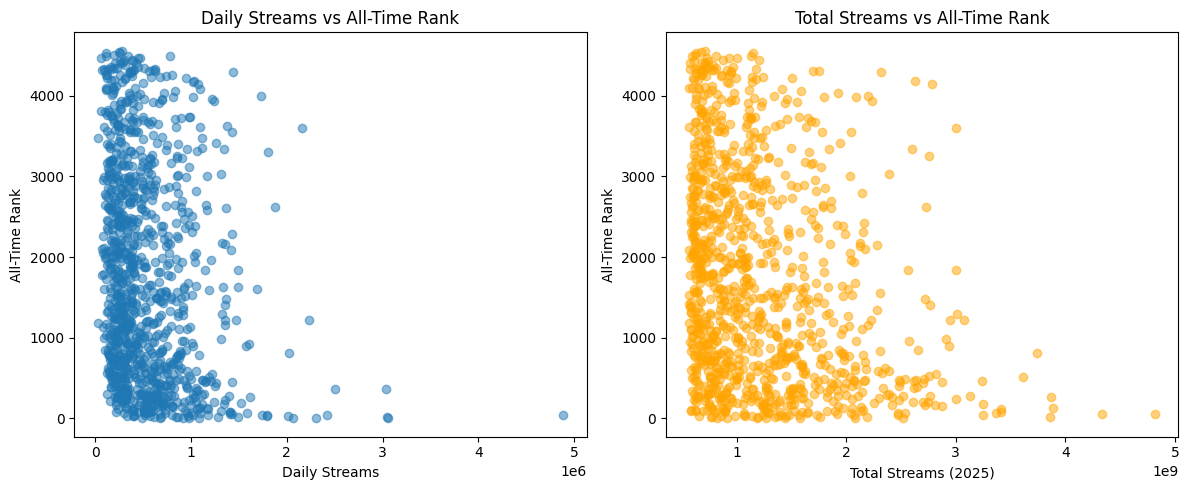

In [ ]:
plt.figure(figsize=(12, 5))

# Plot 1: Daily Streams vs Rank
plt.subplot(1, 2, 1)
plt.scatter(visual_df['daily'], visual_df['all_time_rank'], alpha=0.5)
plt.title('Daily Streams vs All-Time Rank')
plt.xlabel('Daily Streams')
plt.ylabel('All-Time Rank')


# Plot 2: Total Streams vs Rank
plt.subplot(1, 2, 2)
plt.scatter(visual_df['streams_2025'], visual_df['all_time_rank'], alpha=0.5, color='orange')
plt.title('Total Streams vs All-Time Rank')
plt.xlabel('Total Streams (2025)')
plt.ylabel('All-Time Rank')


plt.tight_layout()
plt.show()



Each point in the scatter plots represents a song. We visually compared the density and spread of data to determine which feature better aligns with a song's rank.

### Analysis

- **Daily Streams:**  
  Points cluster more tightly at lower ranks with higher daily streams, indicating a clearer inverse relationship.

- **Total Streams:**  
  Data is more scattered and noisy, showing less consistent correlation with rank.

### Interpretation

- Daily stream counts reflect more immediate and current popularity.
- Total stream counts include long-term listening trends and may reflect outdated popularity.

### Conclusion

Daily streams are a stronger and more relevant predictor of a song’s current rank than total historical streams.


# Do recently released tracks get more daily streams? (Recency Effect)

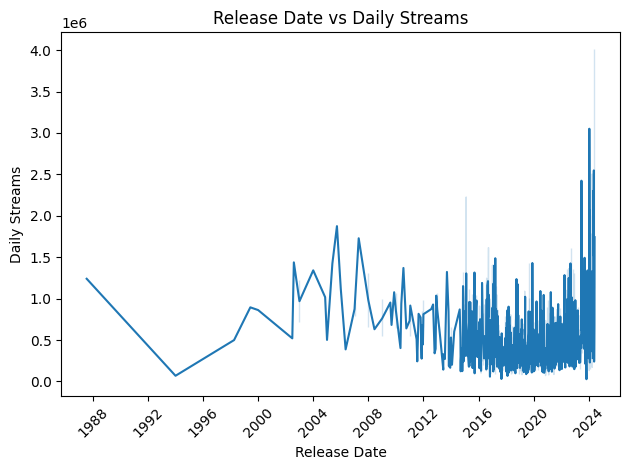

In [29]:
visual_df['release_date'] = pd.to_datetime(visual_df['release_date'])

sns.lineplot(data=visual_df.sort_values('release_date'), x='release_date', y='daily')
plt.title('Release Date vs Daily Streams')
plt.xlabel('Release Date')
plt.ylabel('Daily Streams')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### Analysis

- **Recent Surge:**  
  Songs released after 2020 exhibit significantly higher daily stream counts.

- **Older Tracks:**  
  Even popular older songs tend to have lower daily streams.

### Interpretation

- Streaming behavior favors newly released content.
- Trends may be driven by algorithmic promotion, playlist placements, and viral social media influence.

### Conclusion

Newer tracks consistently receive more daily streams, highlighting the fast-paced and trend-driven nature of modern music consumption.


# Are some genres more associated with high track scores and ranks?

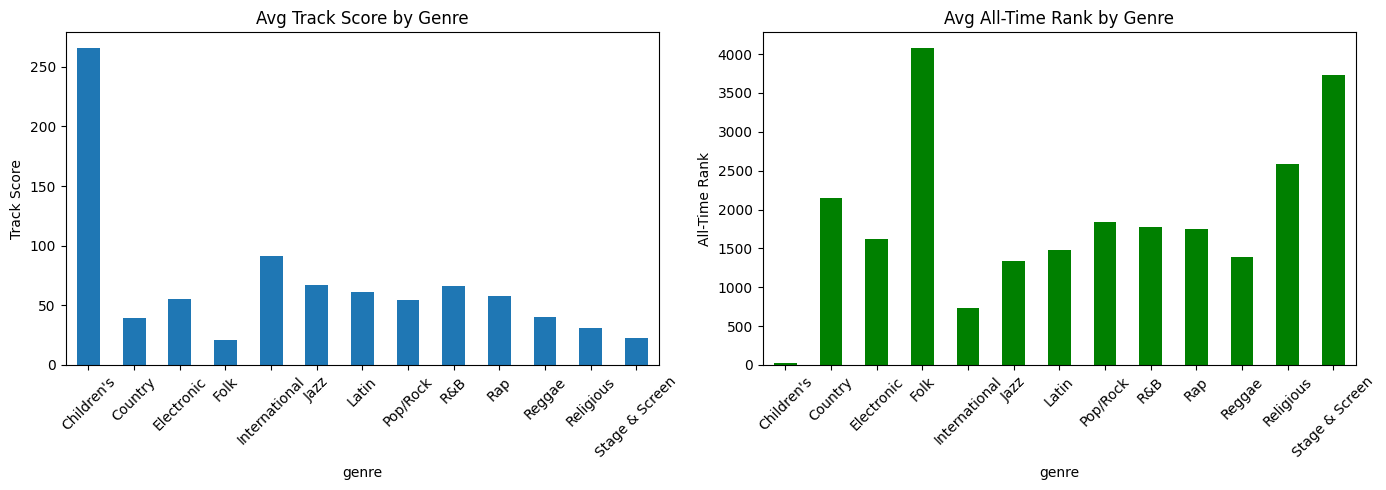

In [31]:
plt.figure(figsize=(14, 5))

# Plot 1: Track Score by Genre
plt.subplot(1, 2, 1)
visual_df.groupby('genre')['track_score'].mean().plot(kind='bar')
plt.title('Avg Track Score by Genre')
plt.ylabel('Track Score')
plt.xticks(rotation=45)

# Plot 2: All-Time Rank by Genre
plt.subplot(1, 2, 2)
visual_df.groupby('genre')['all_time_rank'].mean().plot(kind='bar', color='green')
plt.title('Avg All-Time Rank by Genre')
plt.ylabel('All-Time Rank')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



### Analysis

- **Children’s Music:**  
  Shows the highest average track scores and best (lowest) ranks among all genres.

- **Folk, Stage & Screen:**  
  Consistently associated with lower track scores and poorer rankings.

### Interpretation

- Genres that are algorithmically promoted or reused in specific contexts (e.g., Children’s music) benefit from continuous engagement.
- Niche or less mainstream genres may underperform in rankings despite artistic quality.

### Conclusion

Genre significantly influences streaming performance, with mainstream or functionally driven genres outperforming others in both ranking and scoring metrics.


# Do different genres dominate different platforms?

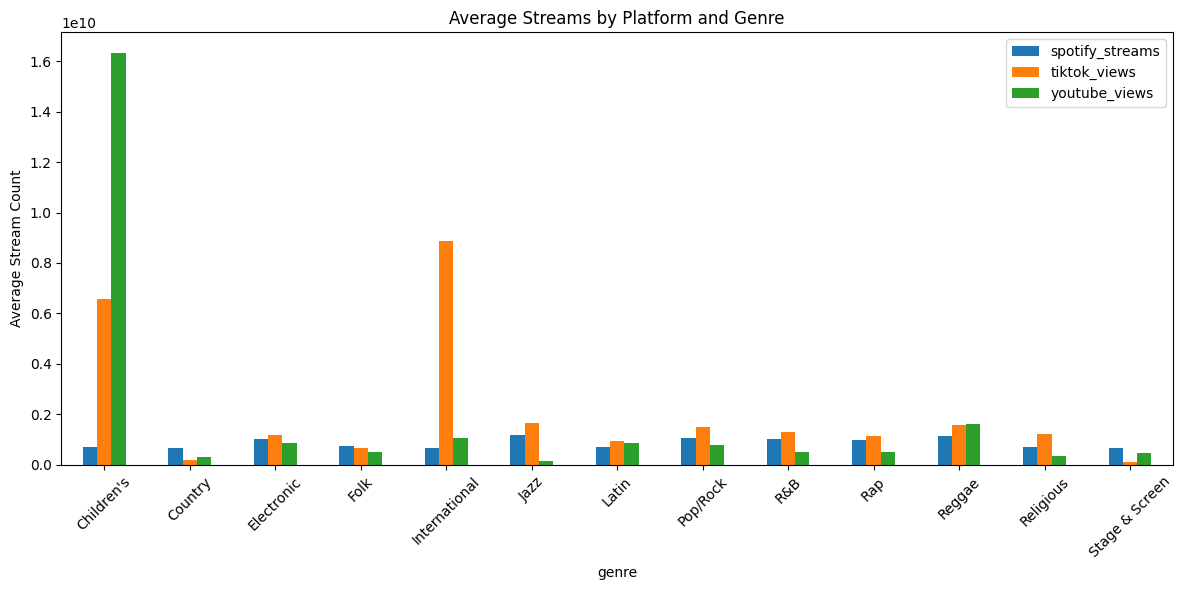

In [15]:
platform_cols = ['spotify_streams', 'tiktok_views', 'youtube_views']
platform_stats = visual_df.groupby('genre')[platform_cols].mean()

platform_stats.plot(kind='bar', figsize=(12, 6))
plt.title('Average Streams by Platform and Genre')
plt.ylabel('Average Stream Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




### Analysis

- **Children’s and International Genres:**  
  Strongly dominate platforms like YouTube and TikTok.

- **Pop/Rock and Rap:**  
  Show consistent, balanced performance across all major platforms.

- **Folk and Religious Genres:**  
  Underperform across the board, with limited platform traction.

### Interpretation

- Each streaming platform has unique user behavior and content preferences.
- YouTube favors visual-heavy or child-oriented content.
- TikTok boosts genres suited for viral, short-form engagement.

### Conclusion

Platform dynamics play a critical role in genre success. Artists can optimize exposure by aligning their content with the strengths of the most compatible platform.


